## 岭回归

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['simhei']
%matplotlib inline

In [2]:
def get_Mat(dataSet):
    xMat = np.mat(dataSet.iloc[:,: -1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [3]:
abalone = pd.read_table('abalone.txt',header = None)

In [4]:
'''
函数功能：求回归系数
参数说明：
    xMat：训练数据特征
    yMat：训练数据标签
    lam：公式中lambda的值
返回：
    ws：回归系数
'''
def ridgeRegres(xMat,yMat,lam=0.2):
    xTx = xMat.T * xMat
    denom = xTx + np.eye(np.shape(xMat)[1]) * lam
    if np.linalg.det(denom) == 0:
        print('行列式为0，奇异矩阵，不能做逆')
        return
    ws = denom.I * (xMat.T * yMat)
    return ws

In [5]:
'''
函数功能：获取在不同λ下的回归系数
参数说明：
    xArr：训练数据的特征
    yArr：训练数据的标签
返回：
    wMat：每个特征在不同λ下的回归系数
'''
def ridgeTest(xArr,yArr):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    yMean = np.mean(yMat,0) # 该函数第二个参数（压缩）=0表示对各列求平均值得到1*n的矩阵，=1表示对给行求平均值m*1矩阵
    yMat = yMat - yMean
    xMeans = np.mean(xMat,0) 
    xVar = np.var(xMat,0) # 每一列 var方差，第二个参数=0表示求样本的无偏估计值(除以N-1)，=1求方差(除以N)   cov协方差
    xMat = (xMat - xMeans)/xVar
    # 上述代码是对xArr和yArr做标准化处理
    
    numTestPts = 30
    wMat = np.zeros((numTestPts,np.shape(xMat)[1]))
    
    for i in range(numTestPts): # λ值改变
        ws = ridgeRegres(xMat,yMat,np.exp(i-10))# 行列格式一样但处理了的数据集 ，行列格式一样但处理了的目标值 ， e的i-10次方
        wMat[i,:] = ws.T # 将第i次每个特征的回归系数向量按行保存到30次测试的第i行
    return wMat

In [6]:
abX,abY = get_Mat(abalone)

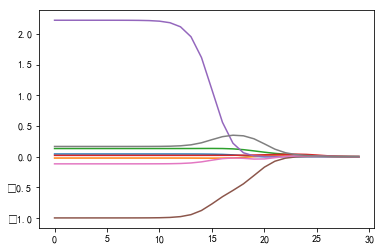

In [7]:
ridgeWeights = ridgeTest(abX,abY)   # 返回 此处30次改变λ值后，得到的30行回归系数
fig = plt.figure()              # 为了看到缩减（惩罚项）的效果而画图
ax = fig.add_subplot(111)       # 及回归系数和惩罚项的关系
ax.plot(ridgeWeights)       # 每列
plt.show()

下面是用第一个lambda算出来的回归系数，去预测鲍鱼年龄

因为在使用岭回归时数据进行了标准化，所以在与预测应该也进行一些处理

In [26]:
regularize(abX)*np.mat(ridgeWeights[23,:]).T+ np.mean(abY)

matrix([[ 8.45714607],
        [ 7.7313703 ],
        [ 9.7904584 ],
        ...,
        [11.96518823],
        [10.69977239],
        [12.49630694]])

对上图的解释：

（按列绘制每个特征随λ变化得线条）
该图绘出了每个回归系数与的关系，在最左边，即λ最小时，可以得到所有系数的原始值（与线性回归一致）；在右边，系数全部缩减成0；

中间部分的某值可以取得最好得预测效果，为了定量得找到最佳参数值，需要进行交叉验证。

另外需要判断哪些变量对数据预测最具影响力。（λ一般选择当所有线条趋于稳定得时候）

## 前向逐步回归

逐步前向回归可以得到与lasso差不多得效果，但更简单，它属于一种**贪心算法**，即每一步都尽可能减少误差，一开始，
所有得权重都设置为1，然后每一步所做的决策时对某个权重增加或减少一个很小的值。

In [9]:
'''
函数功能：真实值和预测值 的平方误差和
参数：
    yArr：真实值
    yHatArr：预测值
返回：
    平方误差和
'''
def rssError(yArr,yHatArr):
    return ((yArr-yHatArr)**2).sum()

In [10]:
'''
函数功能：将数据标准化
参数：
    xMat：训练数据
返回：
    inMat：标准化后的数据
'''
def regularize(xMat):
    inMat = xMat.copy()
    inMeans = np.mean(inMat,0) #计算平均数，然后减去它
    inVar = np.var(inMat,0)
    inMat = (inMat-inMeans)/inVar
    return inMat

In [11]:
'''
函数功能：前向逐步回归，不断地在新获得的权重上更新
参数：
     xArr：训练数据特征
     yArr：训练数据标签
     eps：更新步长
     numIt：循环次数
返回：
    ws：回归系数
'''
def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = np.mat(xArr)
    yMat = np.mat(yArr)
    yMean = np.mean(yMat,0) # 按列求均值
    yMat = yMat - yMean
    xMat = regularize(xMat) # 调用函数标准化数据 在岭回归中同样的处理但直接在函数中
    m,n = np.shape(xMat)
    ws = np.zeros((n,1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    
    
    for i in range(numIt): # 不断更新
        #print(ws.T)  #打印出来便于观察每次权重的变化
        lowerError = float('inf') # 初始化最大误差
        for j in range(n): # 循环每个特征
            for sign in [-1,1]: # 增大或减小
                wsTest = ws.copy()
                wsTest[j] += eps*sign # eps每次迭代的步长
                yTest = xMat*wsTest
                rssE = rssError(yMat.A,yTest.A)   # 预测值和真实值的误差
                if rssE < lowerError:
                    lowerError = rssE
                    wsMax = wsTest # 更新wsMax，ws、wsMax、wsTest三者之间相互copy来保证每次结果的保留和更改

        ws = wsMax.copy() # 当所有特征循环完了，找到错误最小的wsMax赋值给新的ws
    return ws

In [12]:
xArr,yArr = get_Mat(abalone)
w=stageWise(xArr,yArr,0.01,300) 

In [13]:
abY

matrix([[15],
        [ 7],
        [ 9],
        ...,
        [ 9],
        [10],
        [12]], dtype=int64)

In [14]:
abX

matrix([[ 1.    ,  0.455 ,  0.365 , ...,  0.2245,  0.101 ,  0.15  ],
        [ 1.    ,  0.35  ,  0.265 , ...,  0.0995,  0.0485,  0.07  ],
        [-1.    ,  0.53  ,  0.42  , ...,  0.2565,  0.1415,  0.21  ],
        ...,
        [ 1.    ,  0.6   ,  0.475 , ...,  0.5255,  0.2875,  0.308 ],
        [-1.    ,  0.625 ,  0.485 , ...,  0.531 ,  0.261 ,  0.296 ],
        [ 1.    ,  0.71  ,  0.555 , ...,  0.9455,  0.3765,  0.495 ]])

使用前向逐步回归返回的回归系数去预测鲍鱼年龄，同样数据需要做响应的处理

In [15]:
regularize(abX)*w + np.mean(abY)

matrix([[ 8.544082  ],
        [ 7.309826  ],
        [10.49429085],
        ...,
        [11.31489354],
        [ 9.91545865],
        [10.88843082]])

In [29]:
df1 = abalone = pd.read_table('abalone.txt',header = None)
df1.columns=['性别','长度','直径','高度','整体重量','肉重量','内脏重量','壳重','年龄']

In [30]:
df1['岭回归第1个λ预测']= regularize(abX)*np.mat(ridgeWeights[0,:]).T+ np.mean(abY)
df1['岭回归第24个λ预测']= regularize(abX)*np.mat(ridgeWeights[23,:]).T+ np.mean(abY)
df1['前向逐步回归预测']= regularize(abX)*w + np.mean(abY)

In [31]:
df1.head(10)

,性别,长度,直径,高度,整体重量,肉重量,内脏重量,壳重,年龄,岭回归第1个λ预测,岭回归第24个λ预测,前向逐步回归预测
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,8.837587,8.457146,8.544082
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,7.294186,7.731370,7.309826
2,-1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,10.782984,9.790458,10.494291
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,9.334215,9.157548,9.271071
4,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,6.981514,7.409668,6.797688
5,0,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,8.111111,8.162124,8.193909
6,-1,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20,13.248668,10.338147,13.318758
7,-1,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16,11.139983,9.685110,10.927698
8,1,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9,9.366153,9.234559,9.481227
9,-1,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19,12.884634,10.423289,12.505314
